# Continuação do curso ML - Validação de modelos (veículos)

In [1]:
import pandas as pd
import numpy as np

In [2]:
uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"

dados = pd.read_csv(uri).drop(columns=["Unnamed: 0"], axis=1)

In [3]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   preco            10000 non-null  float64
 1   vendido          10000 non-null  int64  
 2   idade_do_modelo  10000 non-null  int64  
 3   km_por_ano       10000 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 312.6 KB


In [4]:
dados.sample(10)

,preco,vendido,idade_do_modelo,km_por_ano
6537,39685.45,1,12,44977.83432
7516,18143.66,1,13,44280.99010
7641,19256.89,1,19,28660.73606
6100,70087.82,0,2,31050.60596
9963,57324.82,1,18,18554.08086
4549,45541.45,1,19,24275.28456
1152,85496.21,0,19,27526.15136
3598,32704.61,1,20,12926.21888
4143,50689.32,1,20,21957.83496
8748,45788.95,1,16,22392.35676


# Resgatando informações do curso anterior:

In [5]:
# situação horrível de "azar" onde as classes estão ordenadas por padrão

dados_azar = dados.sort_values("vendido", ascending=True)
x_azar = dados_azar[["preco", "idade_do_modelo","km_por_ano"]]
y_azar = dados_azar["vendido"]
dados_azar.head()

,preco,vendido,idade_do_modelo,km_por_ano
4999,74023.29,0,12,24812.80412
5322,84843.49,0,13,23095.63834
5319,83100.27,0,19,36240.72746
5316,87932.13,0,16,32249.56426
5315,77937.01,0,15,28414.50704


In [6]:
# Definindo baseline com Dummy

from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier

SEED = 301
np.random.seed(SEED)

modelo = DummyClassifier()

results = cross_validate(modelo, 
                         x_azar, y_azar, 
                         cv = 10, 
                         return_train_score=False)

media = results['test_score'].mean()
std = results['test_score'].std()

acuracia_inferior = (media - 2 * std) * 100
acuracia_superior = (media + 2 * std) * 100

print(f'Accuracy com dummy stratified, 10 folds foi entre {acuracia_inferior:.2f}% e {acuracia_superior:.2f}%')      

Accuracy com dummy stratified, 10 folds foi entre 58.00% e 58.00%


In [7]:
# Baseline com DecisionTreeClassifier

from sklearn.tree import DecisionTreeClassifier

SEED = 158020
np.random.seed(SEED)

modelo = DecisionTreeClassifier(max_depth = 2)

results = cross_validate(modelo, 
                         x_azar, y_azar, 
                         cv = 10, 
                         return_train_score=False)

media = results['test_score'].mean()
std = results['test_score'].std()

acuracia_inferior = (media - 2 * std) * 100
acuracia_superior = (media + 2 * std) * 100

print(f'Accuracy DTC com CV 10 folds foi entre {acuracia_inferior:.2f}% e {acuracia_superior:.2f}%')      

Accuracy DTC com CV 10 folds foi entre 73.83% e 77.73%


In [8]:
# gerando dados elatorios de modelo (de carro) para simulacao de agrupamento ao usar nosso estimador

np.random.seed(SEED)
dados['modelo'] = dados.idade_do_modelo + np.random.randint(-2, 3, size=10000)
dados.modelo = dados.modelo + abs(dados.modelo.min()) + 1
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano,modelo
0,30941.02,1,18,35085.22134,19
1,40557.96,1,20,12622.05362,22
2,89627.50,0,12,11440.79806,14
3,95276.14,0,3,43167.32682,4
4,117384.68,1,4,12770.11290,4


In [9]:
def imprime_resultado(results):
  media = results['test_score'].mean()
  std = results['test_score'].std()

  acuracia_inferior = (media - 2 * std) * 100
  acuracia_superior = (media + 2 * std) * 100

  print(f'Acurácia média é de {media * 100:.2f}%')
  print(f'O intervalo da acurácia foi entre {acuracia_inferior:.2f}% e {acuracia_superior:.2f}%')      

In [10]:
# GroupKFold para analisar como o modelo se comporta com novos grupos

from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)

modelo = DecisionTreeClassifier(max_depth=2)

results = cross_validate(modelo, 
                         x_azar, y_azar, 
                         cv = cv, 
                         groups = dados.modelo, #aqui
                         return_train_score=False)

imprime_resultado(results)

Acurácia média é de 75.76%
O intervalo da acurácia foi entre 72.91% e 78.60%


In [11]:
# GroupKFold em um pipeline com StandardScaler e SVC

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

SEED = 301
np.random.seed(SEED)

scaler = StandardScaler()
modelo = SVC()

pipeline = Pipeline([('transformacao',scaler), ('estimador',modelo)])

cv = GroupKFold(n_splits = 10)

results = cross_validate(pipeline, 
                         x_azar, y_azar, 
                         cv = cv, 
                         groups = dados.modelo, 
                         return_train_score=False)

imprime_resultado(results)

Acurácia média é de 76.66%
O intervalo da acurácia foi entre 73.65% e 79.66%




---



---



# Inicio ML - Otimização de modelos através de hiperparâmetros

Anteriormente, aprendemos que podemos fornecer parâmetros para nossos estimadores/classificadores (como max_depth) antes de eles serem treinados. 

Parâmetros que são definidos antes do treino são chamados de **hiperparâmetros**, e são diferentes de valores internos do modelo que vão sendo alterados de acordo com o que o modelo está aprendendo.

Em nosso exemplo, utilizamos a profundidade máxima de uma árvore de decisão padrão do SkLearn. E qual valor escolheremos para ela? Antes de decidirmos, vamos testar diversos valores e prestar atenção no que acontece. Para isso, rodaremos o DecisionTreeClassifier() várias vezes, de 1 até 32.

In [12]:
# função para rodar DTC

from sklearn.model_selection import GroupKFold

def roda_DTC(max_depth):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)

  modelo = DecisionTreeClassifier(max_depth=max_depth)

  results = cross_validate(modelo, 
                          x_azar, y_azar, 
                          cv = cv, 
                          groups = dados.modelo, #aqui
                          return_train_score=False)

  media = results['test_score'].mean() * 100

  print(f'max_depth: {max_depth}, Média: {media:.2f}')

In [13]:
for i in range (1, 33):
  roda_DTC(i)

max_depth: 1, Média: 75.76
max_depth: 2, Média: 75.76
max_depth: 3, Média: 78.68
max_depth: 4, Média: 78.62
max_depth: 5, Média: 78.50
max_depth: 6, Média: 78.34
max_depth: 7, Média: 77.80
max_depth: 8, Média: 77.86
max_depth: 9, Média: 77.46
max_depth: 10, Média: 76.86
max_depth: 11, Média: 76.81
max_depth: 12, Média: 76.08
max_depth: 13, Média: 75.81
max_depth: 14, Média: 75.61
max_depth: 15, Média: 75.12
max_depth: 16, Média: 75.05
max_depth: 17, Média: 74.57
max_depth: 18, Média: 74.38
max_depth: 19, Média: 74.08
max_depth: 20, Média: 73.78
max_depth: 21, Média: 73.67
max_depth: 22, Média: 73.52
max_depth: 23, Média: 73.64
max_depth: 24, Média: 73.49
max_depth: 25, Média: 72.92
max_depth: 26, Média: 72.86
max_depth: 27, Média: 72.33
max_depth: 28, Média: 72.42
max_depth: 29, Média: 72.34
max_depth: 30, Média: 72.45
max_depth: 31, Média: 71.98
max_depth: 32, Média: 72.13


O que esperaríamos é que, quanto maior fosse a profundidade da árvore, mais decisões ela precisaria tomar e mais perfeito seria o seu treinamento em relação aos nossos testes. Porém, a partir de max_depth=3, que possui uma média 78.67, temos uma queda constante até max_depth = 32, que possui a média mais baixa, 72.52.

Isso acontece porque, quando treinamos a nossa árvore, ela aprende e cria as suas ramificações. Com profundidades muito grandes, a árvore se torna tão perfeita para os dados de treino que falha nos dados de teste - quase como se ela tivesse memorizado o teste.

Vamos verificar se é isso mesmo que está acontecendo?

## Otimizando um hiper parâmetro e o problema do overfit

Além de imprimirmos o valor do teste, queremos imprimir também o valor do treino. Para isso, atribuiremos True para return_train_score e mudaremos o nome das variaveis de média para capturarmos o valor de treino:

In [14]:
# função-2 para rodar DTC

from sklearn.model_selection import GroupKFold

def roda_DTC(max_depth):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)

  modelo = DecisionTreeClassifier(max_depth=max_depth)

  results = cross_validate(modelo, 
                          x_azar, y_azar, 
                          cv = cv, 
                          groups = dados.modelo, 
                          return_train_score=True)  #aqui

  train_score = results['train_score'].mean() * 100  #aqui
  test_score = results['test_score'].mean() * 100 #aqui

  print(f'max_depth: {max_depth}, train_score(%): {train_score:.2f}, test_score(%): {test_score:.2f}')

In [15]:
for i in range(1, 33):
  roda_DTC(i)

max_depth: 1, train_score(%): 75.79, test_score(%): 75.76
max_depth: 2, train_score(%): 75.79, test_score(%): 75.76
max_depth: 3, train_score(%): 78.75, test_score(%): 78.68
max_depth: 4, train_score(%): 78.79, test_score(%): 78.62
max_depth: 5, train_score(%): 78.93, test_score(%): 78.50
max_depth: 6, train_score(%): 79.17, test_score(%): 78.34
max_depth: 7, train_score(%): 79.47, test_score(%): 77.80
max_depth: 8, train_score(%): 79.93, test_score(%): 77.86
max_depth: 9, train_score(%): 80.49, test_score(%): 77.46
max_depth: 10, train_score(%): 81.20, test_score(%): 76.86
max_depth: 11, train_score(%): 82.05, test_score(%): 76.81
max_depth: 12, train_score(%): 83.01, test_score(%): 76.08
max_depth: 13, train_score(%): 84.03, test_score(%): 75.81
max_depth: 14, train_score(%): 85.06, test_score(%): 75.61
max_depth: 15, train_score(%): 86.07, test_score(%): 75.12
max_depth: 16, train_score(%): 87.19, test_score(%): 75.05
max_depth: 17, train_score(%): 88.21, test_score(%): 74.57
max_de

Assim como esperávamos, os treinos serão cada vez melhores, mas rapidamente os dados de teste cairam.

Qqueremos visualizar esses resultados de maneira mais inteligível: criaremos uma variável tabela recebendo um array de três valores: max_depth, train_score e test_score, e retornaremos essa tabela:

In [16]:
# função-3 para rodar DTC

from sklearn.model_selection import GroupKFold

def roda_DTC(max_depth):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)

  modelo = DecisionTreeClassifier(max_depth=max_depth)

  results = cross_validate(modelo, 
                          x_azar, y_azar, 
                          cv = cv, 
                          groups = dados.modelo, 
                          return_train_score=True)  

  train_score = results['train_score'].mean() * 100  
  test_score = results['test_score'].mean() * 100 

  print(f'max_depth: {max_depth}, train_score(%): {train_score:.2f}, test_score(%): {test_score:.2f}')

  tabela = [max_depth, train_score, test_score]

  return tabela

Assim, a função roda_arvoce_de_decisao() está nos devolvendo uma tabela. Existem várias maneiras de agruparmos esses dados. Nesse caso, usaremos uma feature do Python chamada list comprehension.

In [17]:
resultados = [roda_DTC(i) for i in range(1, 33)]

max_depth: 1, train_score(%): 75.79, test_score(%): 75.76
max_depth: 2, train_score(%): 75.79, test_score(%): 75.76
max_depth: 3, train_score(%): 78.75, test_score(%): 78.68
max_depth: 4, train_score(%): 78.79, test_score(%): 78.62
max_depth: 5, train_score(%): 78.93, test_score(%): 78.50
max_depth: 6, train_score(%): 79.17, test_score(%): 78.34
max_depth: 7, train_score(%): 79.47, test_score(%): 77.80
max_depth: 8, train_score(%): 79.93, test_score(%): 77.86
max_depth: 9, train_score(%): 80.49, test_score(%): 77.46
max_depth: 10, train_score(%): 81.20, test_score(%): 76.86
max_depth: 11, train_score(%): 82.05, test_score(%): 76.81
max_depth: 12, train_score(%): 83.01, test_score(%): 76.08
max_depth: 13, train_score(%): 84.03, test_score(%): 75.81
max_depth: 14, train_score(%): 85.06, test_score(%): 75.61
max_depth: 15, train_score(%): 86.07, test_score(%): 75.12
max_depth: 16, train_score(%): 87.19, test_score(%): 75.05
max_depth: 17, train_score(%): 88.21, test_score(%): 74.57
max_de

Para conseguirmos trabalhar melhor com esses dados, vamos transformá-la em um dataframe do Pandas com pd.DataFrame(), passando resultados e os nomes das colunas max_depth, train e test:

In [18]:
resultados = pd.DataFrame(resultados, columns=['max_depth', 'train_score', 'test_score'])
resultados.head()

,max_depth,train_score,test_score
0,1,75.790846,75.759083
1,2,75.790846,75.759083
2,3,78.754487,78.682407
3,4,78.786731,78.622384
4,5,78.934461,78.504096


Agora que temos uma tabela do Pandas, podemos transformá-la em um gráfico:

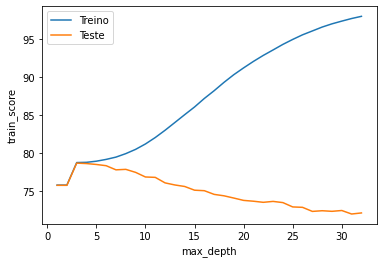

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(x='max_depth', y='train_score', data=resultados)
sns.lineplot(x='max_depth', y='test_score', data=resultados)

plt.legend(['Treino', 'Teste'])

Nele, podemos analisar que conforme aumentamos o max_depth, a média do treino vai ficando cada vez melhor, chegando a quase 100%. Porém, em determinado momento, o algoritmo começa a ficar tão exato para o modelo que deixa de ser adequado para os testes, com a média sendo cada vez menor.

Esse tipo de cenário é chamado de overfitting.

Agora que varremos todo esse espaço de possibilidades, podemos ordenar os resultados a partir da qualidade do teste (resultados.sort_values("test")) de maneira decrescente (ascending=False).

In [20]:
resultados.sort_values('test_score', ascending=False).head()

,max_depth,train_score,test_score
2,3,78.754487,78.682407
3,4,78.786731,78.622384
4,5,78.934461,78.504096
5,6,79.171225,78.340518
7,8,79.931192,77.860485


Podemos perceber as melhores árvores tiveram max_depth = 3, max_depth = 4 ou max_depth = 5. Portanto, usaríamos, por exemplo, max_depth = 3.

## Explorando hiperparâmetros de mais dimensões

Dessa vez, ao invés de rodarmos nossa árvore de decisão para um único parâmetro, a rodaremos para dois. Para isso, criaremos uma cópia do código de roda_arvore_de_decisao(), dessa vez passando max_depth e min_samples_leaf.

In [21]:
# função-4 para rodar DTC

from sklearn.model_selection import GroupKFold

def roda_DTC(max_depth, min_samples_leaf):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)

  modelo = DecisionTreeClassifier(max_depth=max_depth,
                                  min_samples_leaf=min_samples_leaf)  #aqui

  results = cross_validate(modelo, 
                          x_azar, y_azar, 
                          cv = cv, 
                          groups = dados.modelo, 
                          return_train_score=True)  

  train_score = results['train_score'].mean() * 100  
  test_score = results['test_score'].mean() * 100 

  print(f'max_depth: {max_depth}, ',
        f'min_samples_leaf: {min_samples_leaf}, '
        f'train_score(%): {train_score:.2f}, ',
        f'test_score(%): {test_score:.2f}.')

  tabela = [max_depth, min_samples_leaf, train_score, test_score]

  return tabela

Como queremos rodar dois valores por vez, não usaremos list comprehension, pois os resultados não seriam tão facilmente legíveis. Vamos começar passando resultados = [] e, depois, criaremos um for max_depth in range(1,33) que culmina em for min_samples_leaf in range(1,33).

Em seguida, tabela deve receber a função roda_arvore_de_decisao com max_depth e min_samples_leaf. Essa tabela será adicionada nos resultados com resultados.append(tabela).

Como esse código está muito solto, vamos agrupá-lo em uma função busca() que devolve resultados. Por mim, definiremos resultados = busca() e chamaremos busca.head() para imprimir os cinco primeiro elementos desses resultados.

In [22]:
# função busca-1

def busca():
  resultados = []

  for max_depth in range(1, 33):
    for min_samples_leaf in range(1, 33):
      tabela = roda_DTC(max_depth, min_samples_leaf)
      resultados.append(tabela)
  
  resultados = pd.DataFrame(resultados, columns=['max_depth',
                                                 'min_samples_leaf',
                                                 'train_score',
                                                 'test_score'])
  
  return resultados

In [23]:
# comentado pois demora muito pra rodar

# resultados = busca()
# resultados.head()

Rodar esse código todo vai levar muito tempo. Como não queremos isso, ao invés de testarmos todo o espaço do parâmetro min_samples_leaf, rodaremos apenas uma lista com alguns valores:

In [24]:
# função busca-2

def busca():
  resultados = []

  for max_depth in range(1, 33):
    for min_samples_leaf in [32, 64, 128, 256]:  #aqui
      tabela = roda_DTC(max_depth, min_samples_leaf)
      resultados.append(tabela)
  
  resultados = pd.DataFrame(resultados, columns=['max_depth',
                                                 'min_samples_leaf',
                                                 'train_score',
                                                 'test_score'])
  
  return resultados

In [25]:
resultados = busca()

max_depth: 1,  min_samples_leaf: 32, train_score(%): 75.79,  test_score(%): 75.76.
max_depth: 1,  min_samples_leaf: 64, train_score(%): 75.79,  test_score(%): 75.76.
max_depth: 1,  min_samples_leaf: 128, train_score(%): 75.79,  test_score(%): 75.76.
max_depth: 1,  min_samples_leaf: 256, train_score(%): 75.79,  test_score(%): 75.76.
max_depth: 2,  min_samples_leaf: 32, train_score(%): 75.79,  test_score(%): 75.76.
max_depth: 2,  min_samples_leaf: 64, train_score(%): 75.79,  test_score(%): 75.76.
max_depth: 2,  min_samples_leaf: 128, train_score(%): 75.79,  test_score(%): 75.76.
max_depth: 2,  min_samples_leaf: 256, train_score(%): 75.79,  test_score(%): 75.76.
max_depth: 3,  min_samples_leaf: 32, train_score(%): 78.75,  test_score(%): 78.69.
max_depth: 3,  min_samples_leaf: 64, train_score(%): 78.75,  test_score(%): 78.69.
max_depth: 3,  min_samples_leaf: 128, train_score(%): 78.75,  test_score(%): 78.69.
max_depth: 3,  min_samples_leaf: 256, train_score(%): 78.75,  test_score(%): 78.69

Dessa forma, teremos apenas 128 pares de hiperparâmetros testados. Para analisarmos os resultados, vamos imprimir na tela a tabela dos melhores resultados:

In [26]:
resultados.head()

,max_depth,min_samples_leaf,train_score,test_score
0,1,32,75.790846,75.759083
1,1,64,75.790846,75.759083
2,1,128,75.790846,75.759083
3,1,256,75.790846,75.759083
4,2,32,75.790846,75.759083


In [27]:
# melhores resultados
resultados.sort_values("test_score", ascending=False).head()

,max_depth,min_samples_leaf,train_score,test_score
11,3,256,78.751156,78.692477
19,5,256,78.751156,78.692477
15,4,256,78.751156,78.692477
14,4,128,78.751156,78.692477
13,4,64,78.751156,78.692477


Pelo que podemos perceber, os cinco melhores atingiram aproximadamente 78% no teste, todos com max_depth = 4. Já o min_samples_leaf parece não ter influenciado o resultado quando max_depth = 4.

Agora que temos dois hiperparâmetros e estamos em um espaço de duas dimensões, vamos explorar ainda mais esses dados.

## Matriz de correlação e explorando mais e mais espaços de parâmetros

Neste momento, temos uma tabela que indica a situação de dois parâmetros e quão bem um modelo foi no treino e no teste. Nossa dúvida é: como estão se comportando os resultados de treino e de teste em função dos valores de cada parâmetro?

Existe uma dificuldade de apreendermos exatamente o que está acontecendo nesses dados: primeiro, porque a tabela é enorme e estamos mostrando apenas os cinco melhores resultados; e também porque estamos omitindo diversos valores possíveis do nosso teste. Será que o resultado seria melhor se tivéssemos escolhido, por exemplo, min_samples_leaf = 57? E min_samples_leaf = 300?

Testar todas as possibilidades consome muito processamento. Uma das abordagens possíveis - claramente a mais complexa -, seria paralelizar esse processamento, distribuindo-o em várias máquinas.

Outra maneira de tentarmos visualizar se existem espaços de parâmetros melhores para o nosso algoritmo é procurarmos uma relação entre o resultado de teste e esses parâmetros por meio de uma análise de correlação.

In [28]:
corr = resultados.corr()
corr

,max_depth,min_samples_leaf,train_score,test_score
max_depth,1.000000e+00,-2.780775e-16,0.549718,0.043835
min_samples_leaf,-2.780775e-16,1.000000e+00,-0.400989,0.501023
train_score,5.497175e-01,-4.009887e-01,1.000000,0.195611
test_score,4.383526e-02,5.010232e-01,0.195611,1.000000


Quanto mais alto o valor, mais correlacionados estão os elementos na comparação.

Outras conclusões que podemos tirar a partir desses resultados:

* quando max_depth cresce, o treino parece crescer também
* quando min_samples_leaf cresce, o treino cai
* quando max_depth sobe, o teste cai
* quando min_samples_leaf sobe, o teste sobe



```
Cuidado: Note que essa não é uma prova de causalidade, mas um teste de correlação.
```



Uma técnica comum para visualizarmos essa correlação é plotar esses resultados em um gráfico.

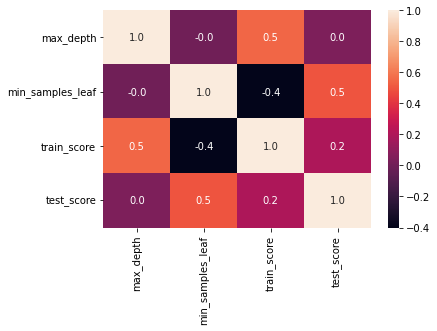

In [29]:
sns.heatmap(corr,
            annot=True,  # para mostrar os valores dentro das caixinhas
            fmt='.1f')  # para mostrar apenas 1 casa decimal

Existem outras maneiras de visualizarmos essa correlação. Dessa vez, usaremos outro tipo de comparação desses valores: uma matriz que mostra os pontos soltos (scatter_matrix()).

Nela, passaremos os resultados, acompanhados de figsize = (14, 8) (para que os gráficos fiquem um pouco maiores e mais fáceis de serem analisados) e alpha = 0.3 (para ajustarmos a transparência dos pontos plotados).

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feb2d1b13d0>,
      dtype=object)

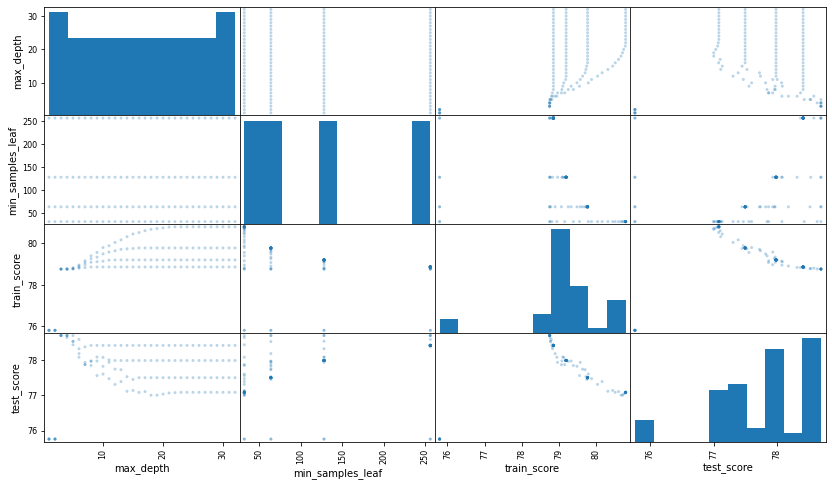

In [30]:
pd.plotting.scatter_matrix(resultados,
                           figsize = (14, 8),
                           alpha = 0.3)

Na diagonal, são exibidos os histogramas dos valores. Por exemplo, para train, tivemos diversos resultados na faixa de 79%, e no test tivemos diversos valores na faixa de 78%.

Já os gráficos que não compõem a diagonal são equivalentes à nossa correlação - à medida em que max_depth aumenta, o resultado de test cai e o resultado de train sobe, entre outras correlações.

Outra visualização possível no Seaborn é o pairplot(), que plota os resultados pareados, de maneira muito parecida com nossa scatter_matrix.

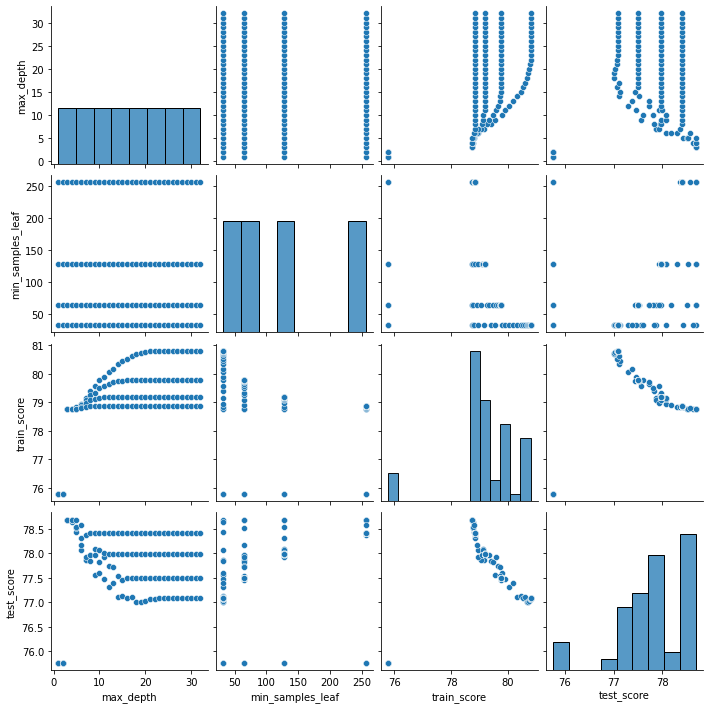

In [31]:
sns.pairplot(resultados)

Na diagonal, teremos novamente os histogramas dos valores. Os outros gráficos fazem os relacionamentos de um parâmetro em função do outro, e novamente podemos analisar que, enquanto max_depth aumenta, o test cai.

No gráfico do canto inferior esquerdo, temos 4 linhas que provavelmente representam cada valor de min_samples_leaf. Entretanto, ao menos nesse gráfico, é impossível visualizarmos qual valor cada linha representa.

Por último, geraremos outro gráfico que consta na própria [documentação do seaborn correlations](https://seaborn.pydata.org/examples/many_pairwise_correlations.html), a matriz de correlação diagonal (diagonal correlation matrix). Para isso, copiaremos o código que consta nessa documentação, apenas removendo os trechos em que os dados são gerados e atribuídos à uma variável corr.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


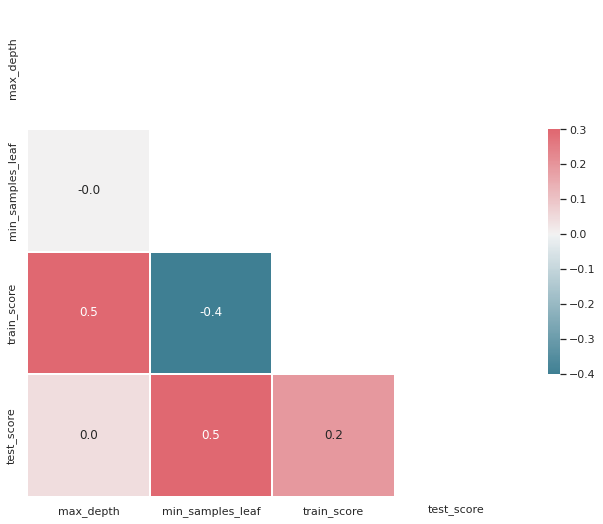

In [32]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, fmt='.1f', mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Repare que somente os dados que nos interessam (ou seja, aqueles que não são equivalentes) são plotados com cores na matriz.

Nela, percebemos que parece existir uma correlação muito forte entre test e min_samples_leaf - quanto maior o min_samples_leaf, maior a qualidade do test.

Com esses dados em mãos, podemos então testar outros valores. Como obtivemos resultados melhores com 128 e 256, vamos mantê-los, adicionando 192 e 512.

In [33]:
# função busca-3

def busca():
  resultados = []

  for max_depth in range(1, 33):
    for min_samples_leaf in [128, 192, 256, 512]:  #aqui
      tabela = roda_DTC(max_depth, min_samples_leaf)
      resultados.append(tabela)
  
  resultados = pd.DataFrame(resultados, columns=['max_depth',
                                                 'min_samples_leaf',
                                                 'train_score',
                                                 'test_score'])
  
  return resultados

Isso não garante que iremos encontrar o melhor valor possível para o nosso parâmetro, mas é uma maneira de explorarmos as possibilidades e resultados.

In [34]:
resultados = busca()
resultados.head()

max_depth: 1,  min_samples_leaf: 128, train_score(%): 75.79,  test_score(%): 75.76.
max_depth: 1,  min_samples_leaf: 192, train_score(%): 75.79,  test_score(%): 75.76.
max_depth: 1,  min_samples_leaf: 256, train_score(%): 75.79,  test_score(%): 75.76.
max_depth: 1,  min_samples_leaf: 512, train_score(%): 75.79,  test_score(%): 75.76.
max_depth: 2,  min_samples_leaf: 128, train_score(%): 75.79,  test_score(%): 75.76.
max_depth: 2,  min_samples_leaf: 192, train_score(%): 75.79,  test_score(%): 75.76.
max_depth: 2,  min_samples_leaf: 256, train_score(%): 75.79,  test_score(%): 75.76.
max_depth: 2,  min_samples_leaf: 512, train_score(%): 75.79,  test_score(%): 75.76.
max_depth: 3,  min_samples_leaf: 128, train_score(%): 78.75,  test_score(%): 78.69.
max_depth: 3,  min_samples_leaf: 192, train_score(%): 78.75,  test_score(%): 78.69.
max_depth: 3,  min_samples_leaf: 256, train_score(%): 78.75,  test_score(%): 78.69.
max_depth: 3,  min_samples_leaf: 512, train_score(%): 77.53,  test_score(%):

,max_depth,min_samples_leaf,train_score,test_score
0,1,128,75.790846,75.759083
1,1,192,75.790846,75.759083
2,1,256,75.790846,75.759083
3,1,512,75.790846,75.759083
4,2,128,75.790846,75.759083


Após executarmos esse código, vamos rodar novamente corr = resultados.corr() e o código que gera a nossa matriz.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


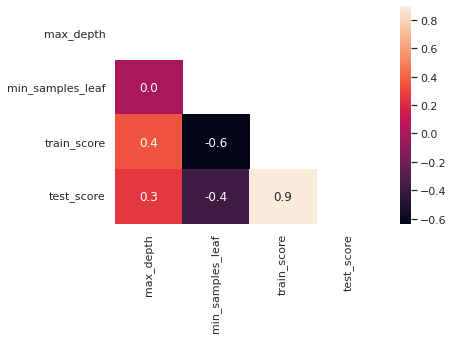

In [35]:
corr = resultados.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr,
            mask=mask,
            annot=True,  # para mostrar os valores dentro das caixinhas
            fmt='.1f')  # para mostrar apenas 1 casa decimal

Dessa vez, o resultado é uma correlação negativa entre min_samples_leaf e test.

Com resultados.sort_values("test", ascending=False).head(), analisaremos outra vez quais foram os cinco melhores resultados desse teste:

In [36]:
resultados.sort_values('test_score', ascending=False).head()

,max_depth,min_samples_leaf,train_score,test_score
18,5,256,78.751156,78.692477
8,3,128,78.751156,78.692477
17,5,192,78.751156,78.692477
14,4,256,78.751156,78.692477
13,4,192,78.751156,78.692477


Essa é uma maneira de tentarmos encontrar os valores que mais otimizam o nosso estimador, com o menor índice de erro e o maior nível de qualidade. Fizemos isso com dois parâmetros, mas é possível trabalhar com um número ainda maior!

## Explorando 3 ou mais hiperparâmetros

Nas aulas anteriores, exploramos um espaço de 2 dimensões, atrelado a 2 parâmetros. Mesmo assim, não exploramos todo o espaço de parâmetros, e mesmo que tenhamos encontrado valores que parecem razoáveis, não temos garantia de que são os melhores possíveis.

Na documentação do DecisionTreeClassifier, encontramos diversos outros parâmetros - e vários deles são hiperparâmetros.

Dessa vez, trabalharemos com min_samples_split.

Antes, estávamos explorando o mínimo de samples em um nó final (a nossa "folha"), e agora exploraremos o mínimo de "quebras" (splits) que podemos ter no meio da árvore.

Para isso, na nossa função busca(), precisaremos criar mais um for, novamente com valores fixos - nesse caso, 32, 64, 128 e 256. Além disso, min_samples_split deve ser adicionado:

* como parâmetro da função roda_arvore_de_decisao()
* como parâmetro de DecisionTreeClassifier().
* como um dos valores de tabela
* como uma das colunas de DataFrame()

In [37]:
# função-5 para rodar DTC

from sklearn.model_selection import GroupKFold

def roda_DTC(max_depth, min_samples_leaf, min_samples_split):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)

  modelo = DecisionTreeClassifier(max_depth=max_depth,
                                  min_samples_leaf=min_samples_leaf,
                                  min_samples_split=min_samples_split)  #aqui

  results = cross_validate(modelo, 
                          x_azar, y_azar, 
                          cv = cv, 
                          groups = dados.modelo, 
                          return_train_score=True)  

  train_score = results['train_score'].mean() * 100  
  test_score = results['test_score'].mean() * 100 

  # muitos parametros, estes prints acabam nao servindo pra nada.
  # print(f'max_depth: {max_depth}, ',
  #       f'min_samples_leaf: {min_samples_leaf}, '
  #       f'train_score(%): {train_score:.2f}, ',
  #       f'test_score(%): {test_score:.2f}.')

  tabela = [max_depth, 
            min_samples_leaf,
            min_samples_split,  #aqui
            train_score,
            test_score]

  return tabela

In [38]:
# função busca-4

def busca():
  resultados = []

  for max_depth in range(1, 33):
    for min_samples_leaf in [128, 192, 256, 512]:
      for min_samples_split in [32, 64, 128, 256]:  #aqui
        tabela = roda_DTC(max_depth, min_samples_leaf, min_samples_split)
        resultados.append(tabela)
  
  resultados = pd.DataFrame(resultados, columns=['max_depth',
                                                 'min_samples_leaf',
                                                 'min_samples_split',
                                                 'train_score',
                                                 'test_score'])
  
  return resultados

In [39]:
%%time
resultados = busca()
resultados.head()

CPU times: user 1min 57s, sys: 261 ms, total: 1min 57s
Wall time: 1min 57s


,max_depth,min_samples_leaf,min_samples_split,train_score,test_score
0,1,128,32,75.790846,75.759083
1,1,128,64,75.790846,75.759083
2,1,128,128,75.790846,75.759083
3,1,128,256,75.790846,75.759083
4,1,192,32,75.790846,75.759083


Em seguida, assim como fizemos anteriormente, vamos analisar a correlação e imprimir o gráfico de matriz de correlação diagonal:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


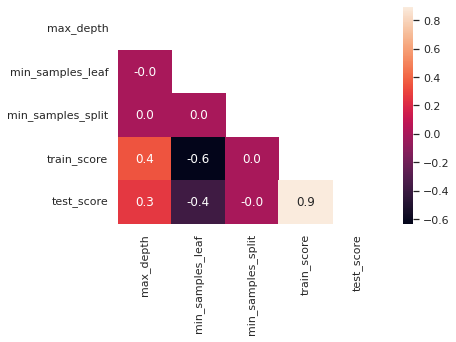

In [40]:
corr = resultados.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr,
            mask=mask,
            annot=True,  # para mostrar os valores dentro das caixinhas
            fmt='.1f')  # para mostrar apenas 1 casa decimal

Com base nesse gráfico e na análise dos 5 melhores resultados do teste, poderíamos tomar uma decisão entre continuar explorando esse espaço de parâmetros ou não.

Outro fator que pode ser analisado é o tempo que a máquina virtual leva para treinar o algoritmo. O próprio cross_validate() tem, entre os seus resultados, a cronometragem do tempo. Portanto, basta extrairmos as variáveis referentes ao tempo e imprimirmos na tabela.

Usaremos fit_time = results['fit_time'].mean() e score_time = results['score_time'].mean() para extrairmos a média de tempo do treino e do teste. Também precisaremos passar fit_time e score_time como parâmetros de tabela e como colunas de DataFrame().

In [41]:
# função-6 para rodar DTC

from sklearn.model_selection import GroupKFold

def roda_DTC(max_depth, min_samples_leaf, min_samples_split):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)

  modelo = DecisionTreeClassifier(max_depth=max_depth,
                                  min_samples_leaf=min_samples_leaf,
                                  min_samples_split=min_samples_split)

  results = cross_validate(modelo, 
                          x_azar, y_azar, 
                          cv = cv, 
                          groups = dados.modelo, 
                          return_train_score=True)  

  train_score = results['train_score'].mean() * 100  
  test_score = results['test_score'].mean() * 100 
  fit_time = results['fit_time'].mean()  #aqui
  score_time = results['score_time'].mean()  #aqui

  tabela = [max_depth, 
            min_samples_leaf,
            min_samples_split,
            train_score,
            test_score,
            fit_time,  #aqui
            score_time]  #aqui

  return tabela

In [42]:
# função busca-5

def busca():
  resultados = []

  for max_depth in range(1, 33):
    for min_samples_leaf in [128, 192, 256, 512]:
      for min_samples_split in [32, 64, 128, 256]:  #aqui
        tabela = roda_DTC(max_depth, min_samples_leaf, min_samples_split)
        resultados.append(tabela)
  
  resultados = pd.DataFrame(resultados, columns=['max_depth',
                                                 'min_samples_leaf',
                                                 'min_samples_split',
                                                 'train_score',
                                                 'test_score',
                                                 'fit_time',  #aqui
                                                 'score_time'])  #aqui
  
  return resultados

In [43]:
%%time
resultados = busca()
resultados.head()

CPU times: user 1min 53s, sys: 229 ms, total: 1min 53s
Wall time: 1min 52s


,max_depth,min_samples_leaf,min_samples_split,train_score,test_score,fit_time,score_time
0,1,128,32,75.790846,75.759083,0.007504,0.002560
1,1,128,64,75.790846,75.759083,0.006909,0.002355
2,1,128,128,75.790846,75.759083,0.006817,0.002488
3,1,128,256,75.790846,75.759083,0.006439,0.002251
4,1,192,32,75.790846,75.759083,0.006696,0.002401


Rodando esse código, iremos testar 512 combinações diferentes de hiperparâmetros no nosso cross_validate(), que são 10 tentativas de treino e teste. Portanto, são 5120 splits de treino/teste no nosso modelo, e por isso a execução demora algum tempo.

Após a execução, geraremos novamente a tabela com os 5 melhores resultados e o gráfico plotando a correlação dos dados:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


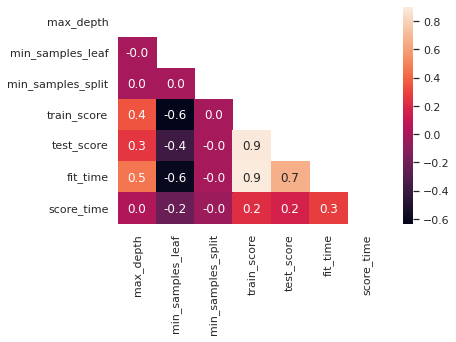

In [44]:
corr = resultados.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr,
            mask=mask,
            annot=True,  # para mostrar os valores dentro das caixinhas
            fmt='.1f')  # para mostrar apenas 1 casa decimal

Repare que existe uma pequena diferença entre os tempos de treino e os treinos de teste. Nesse caso, nosso treino é tão rápido que essas diferenças são insignificantes. Porém, se tivéssemos um algoritmo que demora 30 minutos para fazer o treinamento e no qual o tempo de teste fosse muito alto, talvez valesse a pena escolhermos os valores com base nesses resultados.

Além dos 3 parâmetros que analisamos até agora, o DecisionTreeClassifier possui vários outros, a exemplo do critério de análise da árvore (como e/ou quando quebrar). Esse parâmetro pode receber dois diferentes valores, como gini ou entropy.

Os parâmetros de um algoritmo estimador não precisam ser discretos como os que estudados até o momento. Por exemplo, existem casos em que trabalhamos com escala logarítmica ou exponencial, e é mais interessante explorar valores mais altos ou mais baixos. Ou seja, existem vários tipos de espaços de parâmetros que podem ser explorados.

Agora que aprendemos a trabalhar com 3 parâmetros, lembre-se que é possível utilizar 4, 5 ou dezenas de parâmetros diferentes. Na prática, não há como explorar todas as possibilidades, portanto a ideia é explorarmos somente uma seleção delas - assim como estamos fazendo nesse curso. Com todo o esforço que isso demanda, seria ideal se tivéssemos uma biblioteca que já fizesse esse processo de otimização do nosso modelo.

Felizmente, o SKLearn tem uma maneira de buscar a otimização de parâmetros em um grid., e aprenderemos mais sobre ela a seguir.

# Usando o GridSearchCV

Agora que já aprendemos a importância de uma busca em grid pelos parâmetros que maximizam a métrica que estamos utilizando no nosso sistema, queremos utilizar uma ferramenta que nos ajude nesse processo.

O próprio SKLearn possui o GridSearchCV (grid search cross validation), que faz justamente essa busca de hiperparâmetros com validação cruzada.

Para isso, importaremos o GridSearchCV do sklearn.model_selection. Em seguida, determinaremos o SEED como 301 (mantendo o mesmo seed padrão) e definiremos o nosso espaco_de_parametros.

Ele deve conter diversas dimensões:

* max_depth com os valores 3 e 5
* min_samples_split com os valores 32, 64 e 128
* min_samples_leaf também com os valores 32, 64 e 128
* criterion com os valores gini e entropy (que são strings)

Ou seja, estaremos explorando 4 dimensões diferentes que resultam em 36 combinações.

Nossa busca será um GridSearchCV(), passando DecisionTreeClassifier(), espaco_de_parametros e o cross validation com 10 splits (cv = GroupKFold(n_split = 10)).

O GridSearchCV() vai funcionar como um modelo. Portanto, podemos fazer busca.fit(), que irá rodar o cross validation dentro dele. Portanto, passaremos os parâmetros x_azar e y_azar, e os grupos (groups = dados.modelo). (aqui é modelo dos carros)

Depois da busca, passaremos para o nosso pd.DataFrame() o cv_results_, um dicionário do GridSearchCV que pode ser importado em dataframe do Pandas. Por mim, escreveremos resultados.head() para recebermos os 5 melhores resultados.

In [45]:
# GridSearchCV 1

from sklearn.model_selection import GridSearchCV

SEED = 301
np.random.seed(SEED)

espaco_de_parametros = {
    'max_depth' : [3, 5],
    'min_samples_split' : [32, 64, 128],
    'min_samples_leaf' : [32, 64, 128],
    'criterion' : ['gini', 'entropy']
}

busca = GridSearchCV(DecisionTreeClassifier(),
                     espaco_de_parametros,
                     cv = GroupKFold(n_splits=10))

busca.fit(x_azar, y_azar, groups=dados.modelo)

resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.012633,0.002167,0.002516,0.000388,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.76435,...,0.786869,0.786667,0.809909,0.792453,0.792548,0.77175,0.779124,0.786925,0.012102,1
1,0.011378,0.000064,0.002355,0.000076,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.76435,...,0.786869,0.786667,0.809909,0.792453,0.792548,0.77175,0.779124,0.786925,0.012102,1
2,0.012448,0.002655,0.002424,0.000059,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.76435,...,0.786869,0.786667,0.809909,0.792453,0.792548,0.77175,0.779124,0.786925,0.012102,1
3,0.011423,0.000254,0.002323,0.000081,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.76435,...,0.786869,0.786667,0.809909,0.792453,0.792548,0.77175,0.779124,0.786925,0.012102,1
4,0.011971,0.001227,0.002412,0.000151,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.76435,...,0.786869,0.786667,0.809909,0.792453,0.792548,0.77175,0.779124,0.786925,0.012102,1


Essa tabela nos mostra diversas informações, como a média do tempo de treino, a média do tempo de teste, a acurácia do teste e do treino e o ranking delas, quais foram cada um dos parâmetros utilizados, entre outras.

Com busca.best_params_, podemos imprimir na tela os melhores parâmetros;

e com busca.best_score_ * 100, o melhor resultado em porcentagem:

In [46]:
busca.best_params_

{'criterion': 'gini',
 'max_depth': 3,
 'min_samples_leaf': 32,
 'min_samples_split': 32}

In [47]:
busca.best_score_ * 100

78.69247744191749

Se quisermos o melhor estimador em si, podemos pegá-lo com busca.best_estimator_:

In [48]:
melhor = busca.best_estimator_
melhor

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)

Dado esse resultado, quão bem ele se sairia no mundo real?

No curso anterior, aprendemos que, depois que treinamos o estimador com cross validation, podemos rodar um fit para obtermos o modelo que utilizaremos no mundo real.

Como já temos esse modelo, podemos tentar predizer a sua acurácia com melhor.predict(x_azar), que atribuiremos a uma variável predicoes.

Em seguida, criaremos uma variável accuracy recebendo accuracy_score(predicoes, y_azar) * 100. Lembre-se de importar essa função de sklearn.metrics, do contrário ela não funcionará.

In [49]:
# Utilizar o predict() acaba sendo muito otimista,
# pois acabamos incorrendo em um vício sobre os dados que já tínhamos visto.
# Portanto, essa abordagem deve ser evitada.

from sklearn.metrics import accuracy_score

predicoes = melhor.predict(x_azar)
accuracy = accuracy_score(predicoes, y_azar) * 100

print(f'Accuracy para os dados foi {accuracy:.2f}%')

Accuracy para os dados foi 78.75%


Mas será que esse é mesmo o resultado que esperamos no mundo real?

## Nested cross validation e validando o melhor modelo

Utilizamos o GridSearchCV do SKLearn para encontrarmos o melhor conjunto de hiperparâmetros em um espaço definido, de modo a otimizar a nossa métrica (accuracy).

Quando tentamos analisar quão bem nosso algoritmo se sairia no mundo real, pegamos o melhor conjunto (representado por melhor) e utilizamos um predict() em cima de x_azar - ou seja, com todos os dados e uma única vez.

Porém, durante o nosso processo de aprendizado, utilizamos o cross validation, e existem alguns cuidados que devemos tomar a esse respeito.

Na documentação do SKLearn, encontramos uma seção sobre nested versus non-nested cross-validation. O texto afirma que quando estamos utilizando hiperparâmetros, fazendo, por exemplo, o GridSearchCV junto com o cross_validation_score, não devemos descobrir a nossa métrica por meio do predict(), mas sim com outro cross_valiation_score.

Utilizar o predict() acaba sendo muito otimista, pois acabamos incorrendo em um vício sobre os dados que já tínhamos visto. Portanto, essa abordagem deve ser evitada.

No nosso novo teste, importaremos cross_val_score de sklearn.model_selection.

In [50]:
from sklearn.model_selection import cross_val_score

Em seguida, chamaremos cross_val_score(), passando busca, x_azar e y_azar. O cross validation será o mesmo que estávamos utilizando anteriormente (GroupKFold(n_splits=10), e os grupos serão dados.modelo.

Esse código nos retornará vários scores.

In [51]:
scores = cross_val_score(busca, 
                         x_azar, y_azar,
                         cv = GroupKFold(n_splits=10),
                         groups = dados.modelo)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py", line 891, in fit
    self._run_search(evaluate_candidates)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py", line 1392, in _run_search
    evaluate_candidates(ParameterGrid(self.param_grid))
  File "/

Tentando rodar esse código (no dia 10/08/22), receberemos um erro afirmando que o valor de groups não deve ser none, como se não tivéssemos passado nenhum valor para os grupos. Ou seja, de alguma forma groups não está chegando em GroupKFold() - e é exatamente isso que está acontecendo.

Na verdade, isso ocorre por conta de um bug - o GroupKFold falha na validação cruzada aninhada, e existe até um [tópico no GitHub do scikit sobre esse problema](https://github.com/scikit-learn/scikit-learn/issues/7646). É um bug antigo (o tópico foi criado em 2016), mas continua em aberto, pois é razoavelmente complicado implementar a correção dele.

Como o Pandas não suporta nested validation com o GroupKFold, não conseguiremos prever o resultado para novos grupos. Como alternativa, usaremos o KFold comum, que precisa ser importado de sklearn.model_selection

Além disso, mudaremos o número de splits para 5, adicionaremos o parâmetro shuffle=True e removeremos o parâmetro groups de busca.fit().

Como estamos rodando com KFold normal, essa estimativa é feita sem saber se o grupo é novo ou não.

In [52]:
# GridSearchCV 2 - usando KFold normal devido ao bug citado acima

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

SEED = 301
np.random.seed(SEED)

espaco_de_parametros = {
    'max_depth' : [3, 5],
    'min_samples_split' : [32, 64, 128],
    'min_samples_leaf' : [32, 64, 128],
    'criterion' : ['gini', 'entropy']
}

busca = GridSearchCV(DecisionTreeClassifier(),
                     espaco_de_parametros,
                     cv = KFold(n_splits=5, shuffle=True))

busca.fit(x_azar, y_azar)

resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.011351,0.001588,0.002545,0.000330,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
1,0.011038,0.001223,0.002438,0.000072,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
2,0.010619,0.000334,0.002473,0.000093,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
3,0.010262,0.000028,0.002462,0.000206,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
4,0.010526,0.000286,0.002813,0.000768,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1


Agora podemos rodar o cross_val_score() como gostaríamos, passando KFold(n_splits=5, shuffle=True) no cross validation.

In [53]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(busca,
                         x_azar, y_azar,
                         cv = KFold(n_splits=5, shuffle=True))

scores

array([0.7895, 0.7825, 0.7905, 0.7715, 0.7995])

Com estes valores, é possível reconstruir a média e o intervalo. Para isso, criaremos uma função imprime_scores() que recebe scores. Na media, usaremos scores.mean() * 100, e no desvio scores.std() * 100.

In [54]:
def imprime_scores(scores):
  media = scores.mean() * 100
  desvio = scores.std() * 100
  

  print(f'Accuracy médio: {media:.2f}%')
  print(f'Intervalo: {media - 2 * desvio:.2f}% a {media + 2 * desvio:.2f}%')

In [55]:
imprime_scores(scores)

Accuracy médio: 78.67%
Intervalo: 76.80% a 80.54%


Agora vamos imprimir a árvore de decisão que encontramos como nosso melhor estimador:

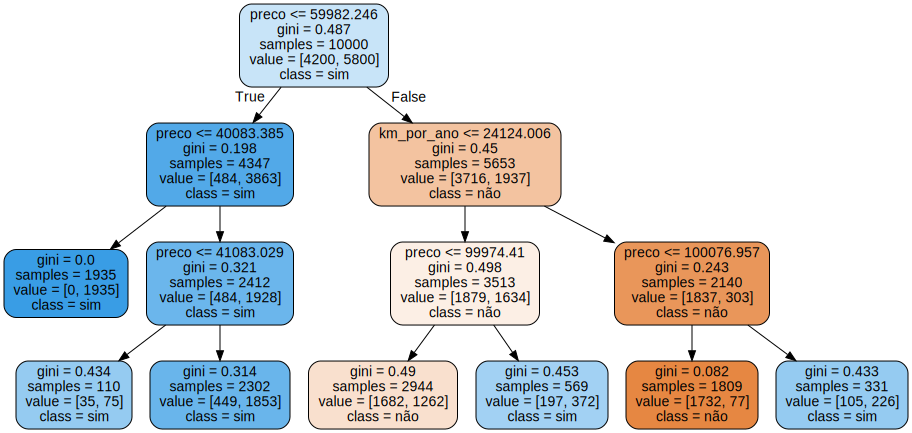

In [56]:
from sklearn.tree import export_graphviz
import graphviz


features = x_azar.columns
dot_data = export_graphviz(melhor, out_file=None, filled=True, rounded=True,
                          class_names=["não","sim"],
                          feature_names=features)
graph = graphviz.Source(dot_data)
graph

Repare que a árvore tem 3 níveis de profundidade (max_depth=3, ou seja, três decisões a serem tomadas), e as folhas e os splits (min_samples_leaf e min_samples_split, respectivamente) têm um mínimo de 32 samples cada. Além disso, as decisões de quebras seguem o critério de gini ao invés de entropy.

Esse é o melhor modelo real que iremos utilizar agora que exploramos o espaço de hiperparâmetros. Esse tipo de exploração com grid, no qual cada espaço é analisado separadamente, é válido e funciona. Porém, é um processo demorado, e existem otimizações que podem ser feitas para contornar isso.

## Questão

Conforme foi demonstrado durante a aula, como funciona o Nested cross validation?

R.: Ele é utilizado quando precisamos buscar hiperparametros para fazer uma nova validação.

Com os hiperparametros, nós colocamos os parametros que gostariamos e fazemos a validação utilizando o nested cross validation.